In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely

In [42]:
all_front=gpd.read_file(r"E:\Mortality\SierraNevada\FrontLine\full_progression_1219_frontline.shp")

In [8]:
Rough=all_front.query("Name=='Rough'")

Generate Equidistance points

Strategy 1: return points for all firelines
return only mid-point for low quality lines (<60m)
return all vertices for lines over 60m and lower than 160m (those that can only generate one point through interpolation)
return interpolated points with an interval of 80m

In [43]:
def equiDistancePoints(line,dist=80,limit=60):
    
    '''
    takes a line and generate equidistance points on it
    dist: specify the distance between points, default 80
    limit: the min value below which lines were low quality, default 60m, 2 landsat pixels
    '''
    
    #generate a series of points along the line that have an interval of around 80m (60-90m)
    #return the centroid point for lines that are lower than 60m
    if line.length<limit: #return the middle point for lines that are lower than 60m (low confidential observations)
        #convert to multipoint as geopandas and Fiona do not allow writing shapefiles with multiple geom types
        return shapely.geometry.MultiPoint([line.interpolate(0.5, normalized = True)])
    elif line.length<(2*dist): # return all vertex for lines that are lower than 160m (otherwise only one interpolated point)
        return shapely.geometry.MultiPoint(line.coords)
        #if len(line.geometry.coords)>2:
            #return shapely.geometry.MultiPoint(line.coords[1:-1]) #exclude start and end point if not line segment
    else:
        #get num of points +1 
        num_points=int(line.length/80)
        #use normalized=True to indicate the given distance value is a fraction to the total length
        new_points = [line.interpolate(i/float(num_points), normalized=True) for i in range(1,num_points)]
        return shapely.geometry.MultiPoint(new_points)
    
    


In [44]:
rand_points=all_front.geometry.apply(equiDistancePoints)

In [45]:
#assign new geometry
all_front_point=all_front.copy()
all_front_point['geometry']=rand_points

In [7]:
all_front_point

,FID_Full_p,Name,gridcode,BurnedArea,Year,time_perce,Elev,Slope,Aspect,TD,...,area_mean,TPA_mean,dtree_mean,mortality_,TPha_weigh,TPha_MWeig,TPA_Class,TPA_MeanCl,front_len,geometry
0,681,Round,39,24.899443,2015,1.000000,1939.240039,13.756932,144.598907,0.576196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2146.217325,"MULTIPOINT (121255.911 -55379.956, 121173.365 ..."
1,681,Round,39,24.899443,2015,1.000000,1939.240039,13.756932,144.598907,0.576196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,20.403568,MULTIPOINT (120401.287 -54100.153)
2,681,Round,39,24.899443,2015,1.000000,1939.240039,13.756932,144.598907,0.576196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,20.403556,MULTIPOINT (120396.344 -54088.205)
3,681,Round,39,24.899443,2015,1.000000,1939.240039,13.756932,144.598907,0.576196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,20.403538,MULTIPOINT (120386.544 -54070.317)
4,681,Round,39,24.899443,2015,1.000000,1939.240039,13.756932,144.598907,0.576196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,20.403526,MULTIPOINT (120381.601 -54058.369)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17773,404,Hidden,324,370.258161,2016,0.857143,2399.935042,27.785185,224.493652,0.958186,...,918094.717857,66.064934,5398.954887,0.247961,72.908095,14.581619,3,2,2133.375545,"MULTIPOINT (123853.593 -195891.296, 123771.726..."
17774,275,Eden,324,24.271539,2018,1.000000,1722.103235,21.102518,278.772461,0.950802,...,107446.682730,29.285730,634.738721,0.442688,183.061740,26.151677,4,2,1736.598687,"MULTIPOINT (111869.321 -178719.315, 111817.255..."
17775,404,Hidden,324,370.258161,2016,0.857143,2399.935042,27.785185,224.493652,0.958186,...,918094.717857,66.064934,5398.954887,0.247961,72.908095,14.581619,3,2,3237.108415,"MULTIPOINT (122341.629 -193989.883, 122413.102..."
17776,404,Hidden,324,370.258161,2016,0.857143,2399.935042,27.785185,224.493652,0.958186,...,918094.717857,66.064934,5398.954887,0.247961,72.908095,14.581619,3,2,755.280180,"MULTIPOINT (124645.037 -195540.490, 124572.931..."


In [150]:
#reorganize data
all_front_p=all_front[['FID_Full_p', 'Name', 'gridcode', 'BurnedArea', 'Year', 'time_perce','front_len']].copy()
all_front_p=gpd.GeoDataFrame(all_front_p, geometry=rand_points)

In [151]:
all_front_p

,FID_Full_p,Name,gridcode,BurnedArea,Year,time_perce,front_len,geometry
0,681,Round,39,24.899443,2015,1.000000,2146.217325,"MULTIPOINT (121338.457 -55379.563, 121252.610 ..."
1,681,Round,39,24.899443,2015,1.000000,20.403568,POINT (120401.287 -54100.153)
2,681,Round,39,24.899443,2015,1.000000,20.403556,POINT (120396.344 -54088.205)
3,681,Round,39,24.899443,2015,1.000000,20.403538,POINT (120386.544 -54070.317)
4,681,Round,39,24.899443,2015,1.000000,20.403526,POINT (120381.601 -54058.369)
...,...,...,...,...,...,...,...,...
17773,404,Hidden,324,370.258161,2016,0.857143,2133.375545,"MULTIPOINT (123935.459 -195896.824, 123850.318..."
17774,275,Eden,324,24.271539,2018,1.000000,1736.598687,"MULTIPOINT (111952.009 -178718.226, 111865.187..."
17775,404,Hidden,324,370.258161,2016,0.857143,3237.108415,"MULTIPOINT (122270.155 -193951.924, 122343.461..."
17776,404,Hidden,324,370.258161,2016,0.857143,755.280180,"MULTIPOINT (124717.143 -195583.424, 124636.024..."


In [46]:
#save generated points
#all_front_point.to_file(r"./full_progression_1219_point_all.geojson", driver='GeoJSON')
all_front_point.to_file(r"./full_progression_1219_point_all.shp", driver='ESRI Shapefile') 

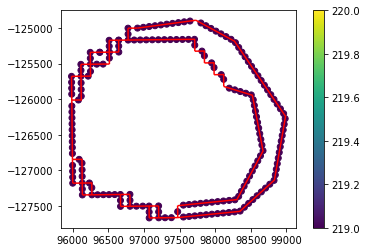

In [9]:
ax=Rough.query("(gridcode<=220)&(gridcode>=219)").plot(color='red')
Rough_p=all_front_point.query("Name=='Rough'")
all_front_point.query("(gridcode<=220)&(Name=='Rough')&(gridcode>=219)").plot(ax=ax,column='gridcode',legend=True)

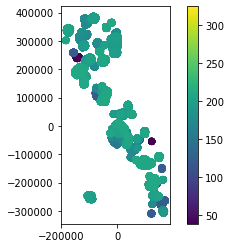

In [23]:
all_front_point.plot(column='gridcode',legend=True)

In [30]:
all_front_point.query("(Name=='Lion')")

,FID_Full_p,Name,gridcode,BurnedArea,Year,time_perce,Elev,Slope,Aspect,TD,...,area_mean,TPA_mean,dtree_mean,mortality_,TPha_weigh,TPha_MWeig,TPA_Class,TPA_MeanCl,front_len,geometry
16517,437,Lion,272.0,155.286839,2017,0.052632,2029.127847,8.350922,218.412994,0.413306,...,171990.573394,3.333333,243.413921,0.110756,9.405052,1.567509,1,1,974.272077,"MULTIPOINT (134062.586 -193593.570, 133981.407..."
16518,437,Lion,272.0,155.286839,2017,0.052632,2029.127847,8.350922,218.412994,0.413306,...,171990.573394,3.333333,243.413921,0.110756,9.405052,1.567509,1,1,0.008961,MULTIPOINT (132935.139 -193777.973)
16519,437,Lion,272.0,155.286839,2017,0.052632,2029.127847,8.350922,218.412994,0.413306,...,171990.573394,3.333333,243.413921,0.110756,9.405052,1.567509,1,1,134.595392,"MULTIPOINT (133069.723 -193775.869, 132935.144..."
16520,437,Lion,272.0,155.286839,2017,0.052632,2029.127847,8.350922,218.412994,0.413306,...,171990.573394,3.333333,243.413921,0.110756,9.405052,1.567509,1,1,1483.302390,"MULTIPOINT (133888.598 -192505.668, 133946.029..."
16521,437,Lion,272.0,155.286839,2017,0.052632,2029.127847,8.350922,218.412994,0.413306,...,171990.573394,3.333333,243.413921,0.110756,9.405052,1.567509,1,1,942.055639,"MULTIPOINT (132999.933 -192443.309, 133085.564..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16865,454,Lion,289.0,202.841783,2017,0.947368,2027.804715,25.474926,102.576485,0.964072,...,359889.941236,8.000101,925.900550,0.177424,27.387861,4.564643,2,1,1340.253878,"MULTIPOINT (143035.857 -193530.771, 143045.671..."
16867,454,Lion,289.0,202.841783,2017,0.947368,2027.804715,25.474926,102.576485,0.964072,...,359889.941236,8.000101,925.900550,0.177424,27.387861,4.564643,2,1,839.621977,"MULTIPOINT (141805.097 -192883.925, 141804.957..."
16868,455,Lion,290.0,34.266567,2017,1.000000,1805.849730,23.521862,87.756973,0.964703,...,84563.518661,6.713492,253.870431,0.246783,44.452471,7.408745,3,1,1221.783230,"MULTIPOINT (143089.784 -193498.293, 143153.525..."
16871,455,Lion,290.0,34.266567,2017,1.000000,1805.849730,23.521862,87.756973,0.964703,...,84563.518661,6.713492,253.870431,0.246783,44.452471,7.408745,3,1,447.683336,"MULTIPOINT (142502.044 -192704.135, 142527.526..."


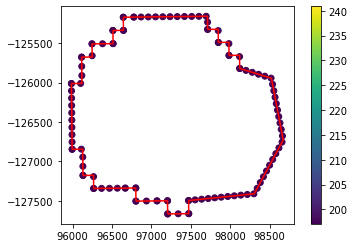

In [135]:
ax=Rough.query("(gridcode<220)&(gridcode>=219)").plot(color='red')
Rough_p=all_front_point.query("Name=='Rough'")
all_front_point.query("(gridcode<220)&(Name=='Rough')&(gridcode>=219)").plot(ax=ax,column='gridcode',legend=True)

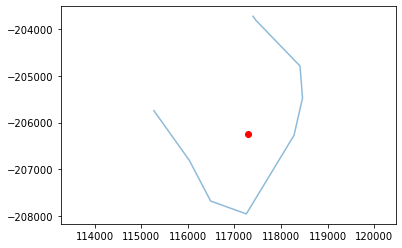

In [77]:
from matplotlib import pyplot as plt
num_points=int(150/80)
line=Pier.iloc[0,:].geometry
#print(num_points)
point=line.centroid
#fig,ax=plt.plot(*line.xy)

fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')  
axs.plot(*line.xy, alpha=0.5)
axs.scatter(point.x,point.y,color='red')

plt.show()



In [42]:
new_points[0].distance(new_points[1])

81.50970585655293

strategy 2:
remove all lines shorter than 60m
generate mid-point for lines <160m and >=60m
generate points with interval of 80m for all other lines

In [35]:
#filter by length
all_front=all_front.query("front_len>=60")

In [36]:
def equiDistancePoints(line,dist=80):
    
    '''
    takes a line and generate equidistance points on it
    dist: specify the distance between points, default 80
    limit: the min value below which lines were low quality, default 60m, 2 landsat pixels
    '''
    
    #generate a series of points along the line that have an interval of around 80m (60-90m)
    if line.length<(2*dist): # return midpoint and  for lines that are lower than 160m (otherwise only one interpolated point)
        return shapely.geometry.MultiPoint([line.interpolate(0.5, normalized = True)])
    else:
        #calculate the number of points to be generated (generate the number-1 instead to exclude the end point)
        num_points=int(line.length/80)
        #use normalized=True to indicate the given distance value is a fraction to the total length
        new_points = [line.interpolate(i/float(num_points), normalized=True) for i in range(num_points)]
        return shapely.geometry.MultiPoint(new_points)
    

In [37]:
rand_points=all_front.geometry.apply(equiDistancePoints)

In [38]:
#assign new geometry
all_front_point=all_front.copy()
all_front_point['geometry']=rand_points

In [39]:
#save file
all_front_point.to_file(r"./full_progression_1219_point_valid.shp", driver='ESRI Shapefile') 

In [53]:
Rough=all_front.query("Name=='Rough'")

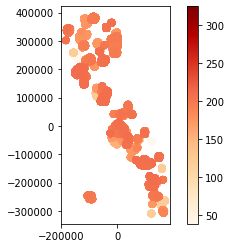

In [82]:
all_front_point.plot(column='gridcode',legend=True, cmap='OrRd')

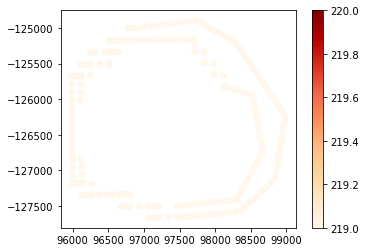

In [83]:
#ax=Rough.query("(gridcode<=220)&(gridcode>=219)").plot(color='red')
#Rough_p=all_front_point.query("Name=='Rough'")
#Rough_p=all_front_point.query("(gridcode<=220)&(Name=='Rough')&(gridcode>=219)")
Rough_p.plot(column='gridcode',legend=True,cmap='OrRd')

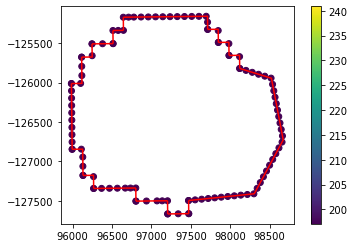

In [55]:
ax=Rough.query("(gridcode<220)&(gridcode>=219)").plot(color='red')
#Rough_p=all_front_point.query("Name=='Rough'")
all_front_point.query("(gridcode<220)&(Name=='Rough')&(gridcode>=219)").plot(ax=ax,column='gridcode',legend=True)

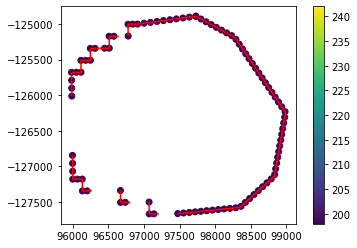

In [78]:
or='red')
#Rough_p=all_front_point.query("Name=='Rough'")
all_front_point.query("(gridcode<=220)&(Name=='Rough')&(gridcode>219)").plot(ax=ax,column='gridcode',legend=True)

Ignition Data:
Data were organized differently each year
Reorganize them seperately

In [60]:
igni.columns

Index(['latitude', 'longitude', 'report_dat', 'hour', 'area_meas', 'fire_name',
       'incident_n', 'per_cont', 'percent_mm', 'cont_date', 'location',
       'start_date', 'start_hour', 'inc_type', 'cause', 'active', 'report_age',
       'gacc', 'internal_i', 'hotlink', 'load_date', 'state', 'area_',
       'geometry'],
      dtype='object')

In [71]:
#load and prepare fire ignition data
igni=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_12.shp")
#save name, date, year,acres
igni=igni[['fire_name','start_date','area_','geometry']]
igni['Year']=2012
igni_new=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_13.shp")
igni_new=igni_new[['fire_name','start_date','area_','geometry']]
igni_new['Year']=2013
igni=pd.concat([igni,igni_new],axis=0)
igni_new=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_14.shp")
igni_new=igni_new[['fire_name','start_date','area_','geometry']]
igni_new['Year']=2014
igni=pd.concat([igni,igni_new],axis=0)
igni_new=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_15.shp")
igni_new=igni_new[['fire_name','start_date','area_','geometry']]
igni_new['Year']=2015
igni=pd.concat([igni,igni_new],axis=0)
igni_new=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_16.shp")
igni_new=igni_new[['incidentna','firediscov','acres','geometry']]
igni_new['Year']=2016
igni_new=igni_new.rename(columns={"incidentna": "fire_name", "firediscov": "start_date","acres":"area_"})
igni=pd.concat([igni,igni_new],axis=0)
igni_new=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_17.shp")
igni_new=igni_new[['FIRENAME','DISCOVERDT','ACRES','geometry']]
igni_new['Year']=2017
igni_new=igni_new.rename(columns={"FIRENAME": "fire_name", "DISCOVERDT": "start_date","ACRES":"area_"})
igni=pd.concat([igni,igni_new],axis=0)
igni_new=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_18.shp")
igni_new=igni_new[['incidentna','firediscov','acres','geometry']]
igni_new['Year']=2018
igni_new=igni_new.rename(columns={"incidentna": "fire_name", "firediscov": "start_date","acres":"area_"})
igni=pd.concat([igni,igni_new],axis=0)
igni_new=gpd.read_file(r"E:/Mortality/SierraNevada/fire/Ignition/GeoMac_ignition_19.shp")
igni_new=igni_new[['incidentna','firediscov','acres','geometry']]
igni_new['Year']=2019
igni_new=igni_new.rename(columns={"incidentna": "fire_name", "firediscov": "start_date","acres":"area_"})
igni=pd.concat([igni,igni_new],axis=0)

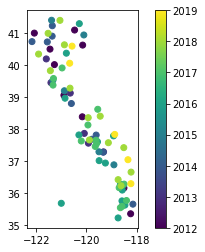

In [76]:
igni.plot(column='Year',legend=True)

In [85]:
len(igni.fire_name.unique())

81

In [96]:
def changeFireName(item):
    
    '''
    takes a row from the fire_name column in the ignition dataset and changes it to the same firename as in progression dataset
    '''
    
    #item=row.fire_name
    
    #for special cases:
    if item=="GARDEN":
        item="Gardensqf"
    elif item=="CABIN":
        item="Cabinsqf"
    elif item=="CHIMNEY":
        item="Chimneyslu"
    elif item=="STONE":
        item="Stonemdf"
    elif item=="CEDAR":
        item="Cedarsqf"
    elif item=="R-1  Ranch":
        item="R1ranch"
    elif item=="CREEK":
        item="Creekstf"
    elif item=="Gulch":
        item="Gulchshu"
    elif item=="LUMPKIN":
        item="Lumpkiin"
    elif item=="SOUP 2":
        item="Soupcomplexsoup2"
    
    if " " in item:
        return item.replace(" ", "").capitalize()
    elif item.isupper():
        return item.capitalize()
    else:
        return item
#igni.fire_name.unique()[27].isupper()

In [99]:
igni['fire_name']=igni.fire_name.apply(changeFireName)

In [100]:
igni

,fire_name,start_date,area_,geometry,Year
0,Jawbonecomplex,08/10/2012,1218.0,POINT (-118.23800 35.34200),2012
1,Reading,07/23/2012,28079.0,POINT (-121.45400 40.49500),2012
2,Robbers,07/11/2012,2650.0,POINT (-120.90000 39.05100),2012
3,Likely,09/05/2012,9838.0,POINT (-120.47300 41.09200),2012
4,Rush,08/12/2012,315577.0,POINT (-120.15200 40.62100),2012
...,...,...,...,...,...
0,Springs,2019-07-26,4840.0,POINT (-118.87220 37.82583),2019
1,Cow,2019-07-25,2025.0,POINT (-118.22750 36.28389),2019
2,Taboose,2019-09-05,10265.0,POINT (-118.34528 37.03417),2019
3,Walker,2019-09-04,54608.0,POINT (-120.66890 40.05325),2019


### Generate Vector Line

In [149]:
all_front_point=gpd.read_file(r"./full_progression_1219_point_all.shp")

In [150]:
#explode the dataset to points
all_front_point=all_front_point.explode().reset_index().rename(columns={"level_0": "line_id", "level_1": "line_id_p"})

In [148]:
fireline=gpd.read_file(r"E:\Mortality\SierraNevada\progression\Full_progression_1219_052620.shp")

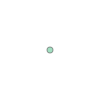

In [138]:
fireline.iloc[0,:].geometry.centroid

In [153]:
fireline.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [152]:
all_front_point.crs

<Projected CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["North ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [154]:
fireline=fireline.to_crs(all_front_point.crs)
fireline.crs

<Projected CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["North ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [160]:
igni=igni.to_crs(all_front_point.crs)

In [168]:
print(date)
days[np.where(days==date)[0][0]-1]

177


176

In [172]:
    #line=all_front_point.iloc[3000,:]
    line=all_front_point.iloc[3000,:]
    print(line)
    date=line.gridcode
    firename=line.Name
    fire=all_front_point.loc[all_front_point['Name']==firename,:]
    days=fire.gridcode.unique()
    print(days)
    if (len(days)==1) or (days[0]==date):
        #exceptions, if not found in ignition dataset
        if firename not in igni.fire_name.unique():
            #if not in ignition dataset, use centroid instead
            prev=fireline.loc[(fireline['Name']==firename)&(fireline['gridcode']==date),:].geometry.centroid.iloc[0]
        else:
            prev=igni.loc[igni['fire_name']==firename].geometry.iloc[0]
        #create a vector line from previous day to current day
        vec_line=shapely.geometry.LineString([prev,line.geometry])
    else:
        #get previous day
        prev_day=days[np.where(days==date)[0][0]-1]
        prev=fireline.loc[((fireline['gridcode']==prev_day)&(fireline['Name']==firename)),:].geometry.unary_union
        #nearest = prev.geometry == nearest_points(point, pts)[1]
        print(shapely.ops.nearest_points(line.geometry,prev)[1])


line_id                                                113
line_id_p                                                2
FID_Full_p                                             458
Name                                                 Lions
gridcode                                               177
                                  ...                     
TPha_MWeig                                         8.59654
TPA_Class                                                3
TPA_MeanCl                                               1
front_len                                           431.34
geometry      POINT (77466.45609341412 -48807.60430076366)
Name: 3000, Length: 69, dtype: object
[175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234]
POINT (77347.82921716095 -49275.01164978445)


In [184]:
def generateVectorLine(line, firedata,ignition,fireline):
    '''
    generate lines connecting current day points to nearest previous day points
    
    args:
    line: points generated on the current fire line (each row from the dataset)
    firedata: the dataset to search for previous day points
    ignition: the ignition dataset to search for starting point of the first day
    fireline: the fireline or burned perimeter dataset to search for centroid
    
    '''
    date=line.gridcode
    firename=line.Name
    fire=firedata.loc[firedata['Name']==firename,:]
    days=fire.gridcode.unique()
    if (len(days)==1) or (days[0]==date):
        #exceptions, if not found in ignition dataset
        if firename not in ignition.fire_name.unique():
            #if not in ignition dataset, use centroid instead
            prev=fireline.loc[(fireline['Name']==firename)&(fireline['gridcode']==date),:].geometry.centroid.iloc[0]
        else:
            prev=ignition.loc[ignition['fire_name']==firename].geometry.iloc[0]
        #create a vector line from previous day to current day
        vec_line=shapely.geometry.LineString([prev,line.geometry])
        return vec_line  
    else:
        #get previous day
        prev_day=days[np.where(days==date)[0][0]-1]
        prev=firedata.loc[((firedata['gridcode']==prev_day)&(firedata['Name']==firename)),:].geometry.unary_union
        #search for closest point
        prev_point=shapely.ops.nearest_points(line.geometry,prev)[1]
        vec_line=shapely.geometry.LineString([prev_point,line.geometry])
        #print if previous day is more than one day before current day
        if date-prev_day>1:
            print("fire name:",firename," fire day:",date," gaps: ",date-prev_day, " doesn't have previous one day record.")
        return vec_line

In [186]:
vec_lines=all_front_point.apply(generateVectorLine,firedata=all_front_point,ignition=igni,fireline=fireline,axis=1)

fire name: Aspen  fire day: 224  gaps:  2  doesn't have previous one day record.
fire name: Aspen  fire day: 224  gaps:  2  doesn't have previous one day record.
fire name: Aspen  fire day: 224  gaps:  2  doesn't have previous one day record.
fire name: Aspen  fire day: 224  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 260  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 260  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 260  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 260  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 264  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 264  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 264  gaps:  2  doesn't have previous one day record.
fire name: Empire  fire day: 266  gaps:  2  doesn't have previous one day record.
fire name: Empire  f

In [256]:
#write records without previous one day perimeter in a dict
prev_day_except={'Aspen':{224:2},
                'Empire':{260:2,264:2,266:2,270:4,274:3,276:2,286:2},
                'Creekstf':{270:2}}

In [191]:
#copy lines
all_vec_lines=all_front_point.copy()
all_vec_lines['geometry']=vec_lines

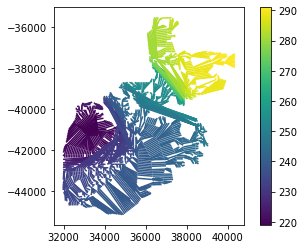

In [201]:
all_vec_lines.loc[all_vec_lines['Name']=='Empire',:].plot(column='gridcode',legend=True)

In [265]:
all_vec_lines.to_file(r"./full_progression_1219_vecline_all.shp", driver='ESRI Shapefile')

calculate length and angle for each line

In [217]:
all_vec_lines=gpd.read_file(r"./full_progression_1219_vecline_all.shp")

In [234]:
def line_angle(line):
    '''
    takes the vector line geometry and calculate the direction of that vector line
    args:
    line: the geometry of the row in geo pandas
    
    return angle value in degrees (ranges from -180(0)-180, 0 degree indicates east, 180 indicates west, 90 is north,-90 is south)
    '''
    
    #use math package
    import math
    
    dy=line.coords[1][1]-line.coords[0][1]
    dx=line.coords[1][0]-line.coords[0][0]
    angle_vec=math.degrees(math.atan2(dy, dx)) #get radiance and convert to degree

    #use numpy
    #connecting=shapely.geometry.LineString([p1,p2])
    #seg = np.array(connecting)
    #seg = seg[1] - seg[0]
    #angle_mid = np.angle(complex(*(seg)), deg=True)
    
    return angle_vec

In [237]:
#calculate vector line direction
all_vec_lines['vec_dir']=all_vec_lines.geometry.apply(line_angle)

In [239]:
#calculate vector line length
all_vec_lines['vec_len']=all_vec_lines.length

In [259]:
#adjust vector line length according to the dict 'prev_day_except'
for key in prev_day_except.keys():
    print(key)
    for key2 in prev_day_except[key].keys():

        all_vec_lines.loc[(all_vec_lines['Name']==key)&(all_vec_lines['gridcode']==key2),'vec_len']=all_vec_lines.loc[(all_vec_lines['Name']==key)&(all_vec_lines['gridcode']==key2),'vec_len']/days


Aspen
Empire
Creekstf


aggregate to each day for each fire: 
- use the first day data (for saving and example showing)
- use mean value (for direction and vector line length)
- use median
- use percentile

In [271]:
all_vec_lines=all_vec_lines.dissolve(by=['Name','gridcode'],aggfunc='mean').reset_index()

In [274]:
all_vec_lines.to_file(r"./full_progression_1219_vecline_083020.shp")

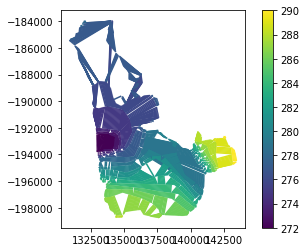

In [216]:
all_vec_lines.loc[all_vec_lines['Name']=='Lion',:].plot(column='gridcode',legend=True)